# Ray tracing for travel time calculation

Ray-tracing through the layered velocity model gives P and S raypaths between the source and receivers as well as the travel times and incident directions at the receivers.

Here we firstly illustrate how to run ray tracing using a 2D example.

In [34]:
import copy
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from math import exp, floor, ceil
from numpy.lib.scimath import sqrt
from numpy import array, linspace, ones, zeros, empty, repeat, \
    transpose, diff, where, real, cumsum, append, multiply, \
    arcsin, finfo, concatenate, square, flipud, max, ceil

%matplotlib notebook

Traceback (most recent call last):
  File "c:\users\zhao\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py", line 215, in process
    func(*args, **kwargs)
  File "c:\users\zhao\appdata\local\programs\python\python37\lib\site-packages\matplotlib\animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


## Velocity model

Figure below is a diagram depicting a horizontally-layered model used for ray-trace modeling, showing P-wave velocity and S-wave velocity for each layer. 

###### Layered Velocity Model #####
[[   0.     1500.      867.052 ]
 [ 120.     3200.     1849.7109]
 [ 850.     3800.     2196.5317]
 [1680.     4150.     2398.844 ]
 [2100.     4500.     2601.156 ]]


<IPython.core.display.Javascript object>


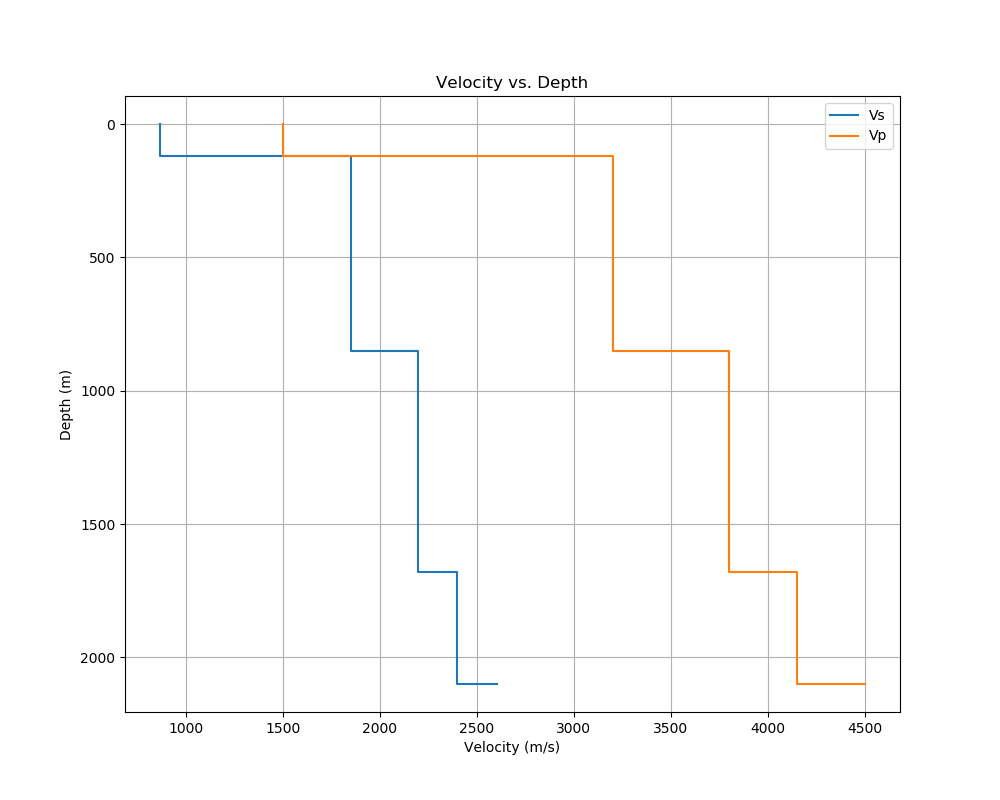

In [35]:
# define layered velocity model, (8,3), 8 layers with depth, vp, vs
vm = np.zeros((5,3), dtype =np.float32)
vm[:,0] = np.array([0., 120., 850., 1680., 2100.]) # depth
vm[:,1] = np.array([1500., 3200., 3800., 4150., 4500.]) # vp
vm[:,2] = vm[:,1]/1.73 # vs
print('###### Layered Velocity Model #####')
print(vm)

# plot layered velocity model
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

vp = vm[:,1]
vs = vm[:,2]
vz = vm[:,0]

ax.step(vs, vz, where='pre', label='Vs')
ax.step(vp, vz, where='pre', label='Vp')

ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Depth (m)')    
ax.invert_yaxis()
ax.legend()
ax.grid(True)

ax.set_title('Velocity vs. Depth')
plt.show()

## Source-receiver geometry

A possible recording geometry for 3D microseismic monitoring is shown on Figure below. 

Arrays of three-component geophones can be placed in one or more observation wells. The wells may have vertical, slanted, and even horizontal sections. The number of geophones in the arrays and the spacing between the geophones in the arrays can be varied. Microseismic sources can be placed at any depth and distance from the observation wells. 

This example will be shown for a single vertical array with 12 geophones spaced at intervals of 20 m.


###### Receivers #####
[[ 100.  800. 1700.]
 [ 100.  800. 1720.]
 [ 100.  800. 1740.]
 [ 100.  800. 1760.]
 [ 100.  800. 1780.]
 [ 100.  800. 1800.]
 [ 100.  800. 1820.]
 [ 100.  800. 1840.]
 [ 100.  800. 1860.]
 [ 100.  800. 1880.]
 [ 100.  800. 1900.]
 [ 100.  800. 1920.]]
###### Sources #####
[[ 800.  500. 1900.]
 [ 800.  400. 2050.]]


<IPython.core.display.Javascript object>


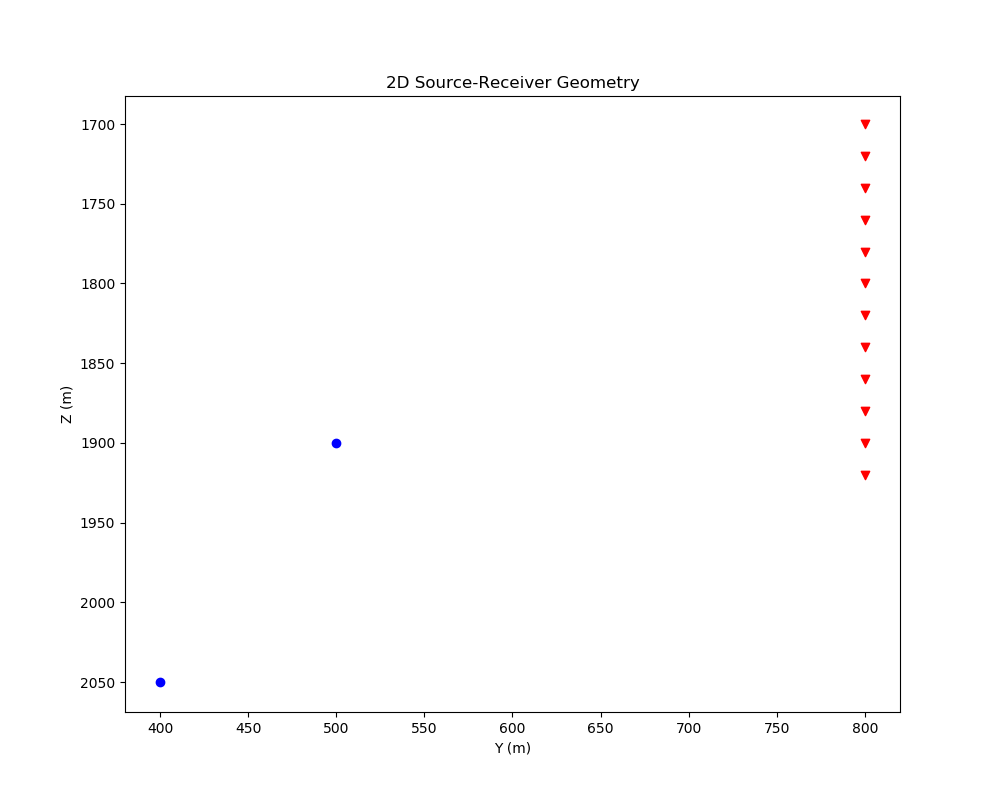

In [36]:
# define receivers coordinates, (12,3), 12 receivers with x,y,z coordinates
rcv = np.ones((12,3), dtype =np.float32)
rcv[:,0] = rcv[:,0] * 100. # x
rcv[:,1] = rcv[:,1] * 800. # y
rcv[:,2] = np.arange(1700.,1940.,20.) # depth
print('###### Receivers #####')
print(rcv)

# define source coordinates, (2,3), 2 source points with x,y,z coordinates
src = np.ones((2,3), dtype =np.float32)
src[0,:] = np.array([800., 500., 1900.])
src[1,:] = np.array([800., 400., 2050.])
nsrc = src.shape[0]
print('###### Sources #####')
print(src)

# plot source-receiver in 2D
# Display sources and receivers locations
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

ax.scatter(rcv[:,1], rcv[:,2], c='r', marker='v')
ax.scatter(src[:,1], src[:,2], c='b', marker='o')
ax.invert_yaxis()
ax.set_xlabel('Y (m)')
ax.set_ylabel('Z (m)')
ax.set_title('2D Source-Receiver Geometry')

plt.show()

## Raytracing using shooting method

Ray tracing can be done either by ray shooting or by ray bending method. Here we use shooting method and below is the function.

In [37]:
def shooting(vpp, vps, zn, xx, xs, xr, ops):
    # some constants
    itermax = 50
    offset = abs(xs.reshape(-1) - xr.reshape(-1))
    
    xc = 10

    # determin option
    if (ops == 1):
        vh = vpp
    elif (ops == 2):
        vh = vps

    # initial guess of the depth & time
    zh = zn - finfo("float32").eps 
  
    
    t = float("inf") * ones((len(offset),), dtype=np.float32)
    # t = exp(100) * ones((len(offset),), dtype=np.float32)
    
    p = float("inf") * ones((len(offset),), dtype=np.float32)
    # p = exp(100) * ones((len(offset),), dtype=np.float32)

    # start raytracing
    # trial shooting
    pmax = 1 / min(vh)   
    pp = np.linspace(0, 1 / max(vh), len(xx)).reshape(1,-1)    
    temp = np.array(vh[0:len(zh)]).reshape(-1,1)   
    sln = temp.dot(pp) - exp(-20)
  
    vel = temp.dot(ones((1, np.size(pp,1)), dtype= np.float32)) # a.dot(b) matrix multiply
 
   
    if len(zh) >2:
        dz = np.array(abs(diff(zh, axis=0))).dot(ones((1, np.size(pp,1))))
    elif len(zh) == 2:
        temp1 = np.array(abs(diff(zh, axis=0))).reshape(-1,1)
        
        dz = temp1.dot(ones((1, np.size(pp,1))))
    else:
        temp2 = np.array(abs(zh)).reshape(-1,1)
        
        dz = temp2.dot(ones((1, np.size(pp,1))))
    
    
    dim_sln = sln.shape
    
    if (dim_sln[0] > 1):
        xn = np.sum((dz * sln) / sqrt(1 - sln**2), axis=0) # need to assign axis
       
        tt = np.sum(dz / (vel * sqrt(1 - sln**2)), axis=0)
        
    else:
        xn =(dz * sln) / sqrt(1 - sln**2) # a * b element-wise multiply
        tt = dz / (vel * sqrt(1 - sln**2)) # a / b element-wise divide
 
    
    if xn.ndim>1:
        xn = xn[0,:]
        tt = tt[0,:]
    pp = pp[0,:]

    
    xmax = xn.max()
   

    # bisection method
    # start bisection method

    for k in range(len(offset)):
        
        # analyze the radius of target
        n = len(xn)        
        xa = xn[0:n - 1].flatten()       
        xb = xn[1:n].flatten()
       
        opt1 = empty((1, n - 1)).flatten()
        opt2 = empty((1, n - 1)).flatten()
        opt = empty((1, n - 1)).flatten()
        for i in range(n - 1):
            if xa[i] <= offset[k] and xb[i] > offset[k]:
                opt1[i] = 1
            else:
                opt1[i] = 0

            if xa[i] >= offset[k] and xb[i] < offset[k]:
                opt2[i] = 1
            else:
                opt2[i] = 0

        opt = opt1 + opt2      

        
        ind = where(opt == 1)

      
        if len(ind) == 0:
            if (offset(k) >= xmax):
                a = n
                b = []
            else:
                a = []
                b = 1
        else:
            a = ind[0]
            b = ind[0] + 1
       

        x1 = xn[a]
        x2 = xn[b]
        t1 = tt[a]
        t2 = tt[b]
        p1 = pp[a]
        p2 = pp[b]
        iter = 0
        err = (b - a) / 2
        
        # Minimize the error & intersect the reflector        
        while((iter < itermax) and abs(err) < 1):
            
            iter = iter + 1
            xt1 = abs(offset[k] - x1)
            xt2 = abs(offset[k] - x2)
            if (xt1 < xc) and (xt1 <= xt2):
                # linear interpolation
                t[k] = t1 + (offset[k] - x1) * (t2 - t1) / (x2 - x1)
                p[k] = p1 + (offset[k] - x1) * (p2 - p1) / (x2 - x1)
            elif (xt2 < xc) and (xt2 <= xt1):
                t[k] = t2 + (offset[k] - x2) * (t1 - t2) / (x1 - x2)
                p[k] = p2 + (offset[k] - x2) * (p1 - p2) / (x1 - x2)
            # set new ray parameter
            if a.size == 0:
                p2 = p1
                p1 = 0
            elif b.size == 0:
                p1 = p2
                p2 = pmax
           
            pnew = linspace(array([p1, p2]).min(), array([p1, p2]).max(), 3)
            pnew = pnew.reshape(1,-1)
            pnew2 = (pnew[:, 1]).reshape(1,1)
            
           

            # do shooting by new ray parameter
            temp = np.array(vh[0:len(zh)]).reshape(-1,1)
                        
            sln = temp.dot(pnew2) 
            
            
            vel = temp.dot(ones((1, len(pnew2)))) # a.dot(b) matrix multiply
            
           
            if len(zh) >2:
                dz = np.array(abs(diff(zh, axis=0))).dot(ones((1, len(pnew2))))
            elif len(zh) == 2:
                temp1 = (abs(diff(zh, axis=0))).reshape(1,1)                
                dz = temp1.dot(ones((1, len(pnew2))))
            else:
                temp2 = (abs(zh)).reshape(1,1)
                
                dz = temp2.dot(ones((1, len(pnew2))))
            
            
            dim_sln = sln.shape
            
            if (dim_sln[0] > 1):
                xtemp = sum((dz * sln) / sqrt(1 - sln**2))                
                ttemp = sum(dz / (vel * sqrt(1 - sln**2)))
                
            else:
                xtemp = (dz * sln) / sqrt(1 - sln**2)
                ttemp = dz / (vel * sqrt(1 - sln**2))
            xnew = array([x1, xtemp[0], x2]).flatten()          
            tnew = array([t1, ttemp, t2]).flatten()
            
          
            xmax = xnew.max()
          
            # analyze the radius of target
            n = len(xnew)           
            xa = xnew[0:n - 1]          
            xb = xnew[1:n]
          
            opt1 = empty((1, n - 1)).flatten()
            opt2 = empty((1, n - 1)).flatten()
            opt = empty((1, n - 1)).flatten()

            for i in range(n - 1):
                
                if xa[i] <= offset[k] and xb[i] > offset[k]:
                    opt1[i] = 1
                else:
                    opt1[i] = 0
                if xa[i] >= offset[k] and xb[i] < offset[k]:
                    opt2[i] = 1
                else:
                    opt2[i] = 0

            opt = opt1 + opt2            
            
            ind = where(opt == 1)            
            
            a = ind[0]
            b = ind[0] + 1
            
            pnew = pnew[0]            
            
            x1 = xnew[a]
            x2 = xnew[b]
           
            t1 = tnew[a]
            t2 = tnew[b]
            p1 = pnew[a]
            p2 = pnew[b]
            err = (b - a) / 2

            # declare ray parameter
            if xr[0] > xs[0]:
                pp = p
            else:
                pp = -p
            # compute travel time & angle
            dx = real((pp * vh * dz) / sqrt(1 - pp * pp * vh * vh))
           
            xx = xs + cumsum(dx)
           
            xh = append(xs, xx)
            xh.reshape(-1,1)
           
            dz = real(dx * sqrt(1 - pp * pp * vh * vh)) / (pp * vh)
            dt = dz / (vh * sqrt(1 - pp * pp * vh * vh))
            tt = cumsum(dt)
            tt_size = tt.size
            time = tt[tt_size - 1]
        

            teta = real(arcsin(multiply(pp, vh)))
          
    
    return xh, zh, vh, pp, teta, time

In [38]:
def directshooting(vpp, vps, zn, xx, xs, xr, ops):
    # Horizontal path
    if xs < xr:
        xh = np.array([xs[0], xr[0]])
    else:
        xh = np.array([xr[0], xs[0]])

    zh = zn
    vh = vpp
    teta = np.array([0.0])
    

    if ops == 1:
        pp = 1 / vpp
        time = abs(np.diff(xh)) / vpp[0]
    else:
        pp = 1 / vps
        time = abs(np.diff(xh)) / vps[0]

    return xh, zh, vh, pp, teta, time[0]

In [39]:
def raytrace(vp, vs, zlayer, dg, src, rcv):
    #  Input geometry
    sourcex = src[:,0]
    sourcey = src[:,1]
    sourcez = src[:,2]
    receiverx = rcv[:,0]
    receivery = rcv[:,1]
    receiverz = rcv[:,2]

    max_x = max(sourcex)
    max_y = max(sourcey)
    topright_dis = ceil(sqrt(max_x*max_x + max_y*max_y)) + dg
    xmin = 0
    xmax = topright_dis
    # Make strata layer
    xx = np.arange(xmin, xmax, dg)
   

    # P wave velocity
    vp = vp.reshape(-1,1)
    vs = vs.reshape(-1,1)

    # Source-Receiver Groups
    # Source
    zs = sourcez
    xs = sourcex - sourcex
    ns = len(xs)
    # Receiver
    zr = receiverz
    nr = len(zr)
    xr = empty((nr, 1), dtype="float32")

    nray = ns * nr

    times = np.zeros((nray, 1), dtype="float32").flatten()
    thetas = np.zeros((nray, 1), dtype="float32").flatten()

    dxList = []
    dyList = []
    zhList = []

    # Run Ray tracing
    # # Loop over for number of souce
    for i in range(ns):   
                
        # Loop over for number of receiver
        for j in range(nr):
            
            xr[j] = sqrt((sourcex[i] - receiverx[j]) * (sourcex[i] - receiverx[j]) +
                         (sourcey[i] - receivery[j]) * (sourcey[i] - receivery[j]))
           
            # Compare zs and zr to determine downgoing or upgoing shooting
            if zs[i] > zr[j]:
                #  Upgoing path
                ind = where(zlayer < zs[i])
                u = array(ind[0]).reshape(-1)
               

                if len(u) == 0:
                    eup = len(zlayer)
                else:
                    eup = u[-1]
                ind = where(zlayer > zr[j])
                u = array(ind[0]).reshape(-1)
               

                if len(u) == 0:
                    sup = len(zlayer)
                else:
                    sup = u[0]

                if sup > eup:                    
                    zu = append(zr[j], zs[i])
                   
                elif sup == eup:
                    zuu = append(zr[j], zlayer[sup])
                    zu = append(zuu, zs[i])
                    
                else:
                    zuu = append(zr[j], zlayer[sup:eup+1])
                    zu = append(zuu, zs[i])
                    
                zu = zu.reshape(-1,1)
                nu = len(zu)
                zn = flipud(zu)

                # Upgoing elastic parameter
                if sup - 1 == eup:
                    vpu = vp[sup - 1]
                    vsu = vs[sup - 1]
                else:
                    vpu = vp[sup - 1:eup + 1]
                    vsu = vs[sup - 1:eup + 1]

                # Combine model elastic parameter
                vpp = flipud(vpu)
                vps = flipud(vsu)

                # Start Raytracing (P-P, S-S, or P-S mode)
                ops = 1
                sx = array([xs[i]])
                rx = array([xr[j]])
                # ops=1 for PP mode; ops=2 for PS mode
                xh, zh, vh, pp, teta, ttime = shooting(
                    vpp, vps, zn, xx, sx, rx,  ops)
                if xs[i] == xr[j]:
                    zv = abs(diff(zn, axis=0))
                    tv = zv / vpp
                    tt = cumsum(tv)
                    tt_size = tt.size
                    ttime = tt[tt_size - 1]

            elif zs[i] == zr[j]:

                # Horizontal path
                ind = where(zlayer < zs[i])
                h = array(ind[0]).reshape(-1)
                

                if len(h) == 0:
                    hor = 0
                else:
                    hor = h[-1]

                zhor = append(zs[i], zr[j])
                nu = len(zhor)
                zn = zhor.reshape(-1,1)

                # Upgoing elastic parameter
                vph = vp[hor]
                vsh = vs[hor]

                # Combine model elastic parameter
                vpp = vph
                vps = vsh

                # Start Raytracing(P - P, S - S, or P - S mode)
                ops = 1
                # ops = 1 for PP mode, ops = 2 for PS mode
                sx = array([xs[i]])
                rx = array([xr[j]])
                xh, zh, vh, pp, teta, ttime = directshooting(
                    vpp, vps, zn, xx, sx, rx, ops)

            else:
                # Downgoing path
                ind = where(zlayer > zs[i])
                d = array(ind[0]).reshape(-1)
                

                if len(d) == 0:
                    sdown = len(zlayer)
                else:
                    sdown = d[0]

                ind = where(zlayer < zr[j])
                d = array(ind[0]).reshape(-1)
               

                if len(d) == 0:
                    edown = len(zlayer)
                else:
                    edown = d[-1]

                if sdown > edown:
                    zd = append(zs[i], zr[j])
                    
                elif sdown == edown:
                    zdd = append(zs[i], zlayer[sdown])
                    zd = append(zdd, zr[j])
                    
                else:
                    zdd = append(zs[i], zlayer[sdown:edown+1])
                    zd = append(zdd, zr[j])
                   
                zd = zd.reshape(-1,1)
                nd = len(zd)
                zn = zd

                # Downgoing elastic parameter
                if sdown - 1 == edown:
                    vpd = vp[sdown - 1]
                    vsd = vs[sdown - 1]
                else:
                    vpd = vp[sdown - 1: edown + 1]
                    vsd = vs[sdown - 1: edown + 1]

                # Combine model elastic parameter
                vpp = vpd
                vps = vsd

                # Start Raytracing(P - P, S - S, or P - S mode)
                ops = 1
                # ops = 1 for PP mode, ops = 2 for PS mode
                sx = array([xs[i]])
                rx = array([xr[j]])
                xh, zh, vh, pp, teta, ttime = shooting(
                    vpp, vps, zn, xx, sx, rx, ops)
                
                if xs[i] == xr[j]:
                    zv = abs(diff(zn, axis=0))
                    tv = zv / vpp
                    tt = cumsum(tv)
                    tt_size = tt.size
                    ttime = tt[tt_size - 1]

            # Store traveltimes and incidence angles
 
            times[i * nr + j] = ttime
            thetas[i * nr + j] = abs(teta[len(teta) - 1])


            # Plot Ray
            
            L = sqrt((sourcex[i] - receiverx[j]) * (sourcex[i] - receiverx[j]) + (sourcey[i] - receivery[j]) * (sourcey[i] - receivery[j]))
            X = sourcex[i] - receiverx[j]
            Y = sourcey[i] - receivery[j]

            
            if L == 0.0:
                L = 1

            if X <= 0:
                dx = sourcex[i] + xh/L * abs(X)
            else:
                dx = sourcex[i] - xh/L * abs(X)
            
            
            if Y <= 0:
                dy = sourcey[i] + xh/L * abs(Y)
            else:
                dy = sourcey[i] - xh/L * abs(Y)

            dxList.extend(copy.deepcopy(dx.flatten()))
            dyList.extend(copy.deepcopy(dy.flatten()))
            zhList.extend(copy.deepcopy(zh.flatten()))
            
    
    rays = np.array(dxList+dyList+zhList).reshape(3,-1)                 
                
                

    return times, rays, thetas

## 2D Example

Carry out raytracing for this 2D model.

c:\users\zhao\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:224: RuntimeWarning: invalid value encountered in true_divide
c:\users\zhao\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:231: RuntimeWarning: invalid value encountered in multiply
c:\users\zhao\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:232: RuntimeWarning: invalid value encountered in multiply
c:\users\zhao\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:232: RuntimeWarning: invalid value encountered in true_divide
c:\users\zhao\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in arcsin


<IPython.core.display.Javascript object>


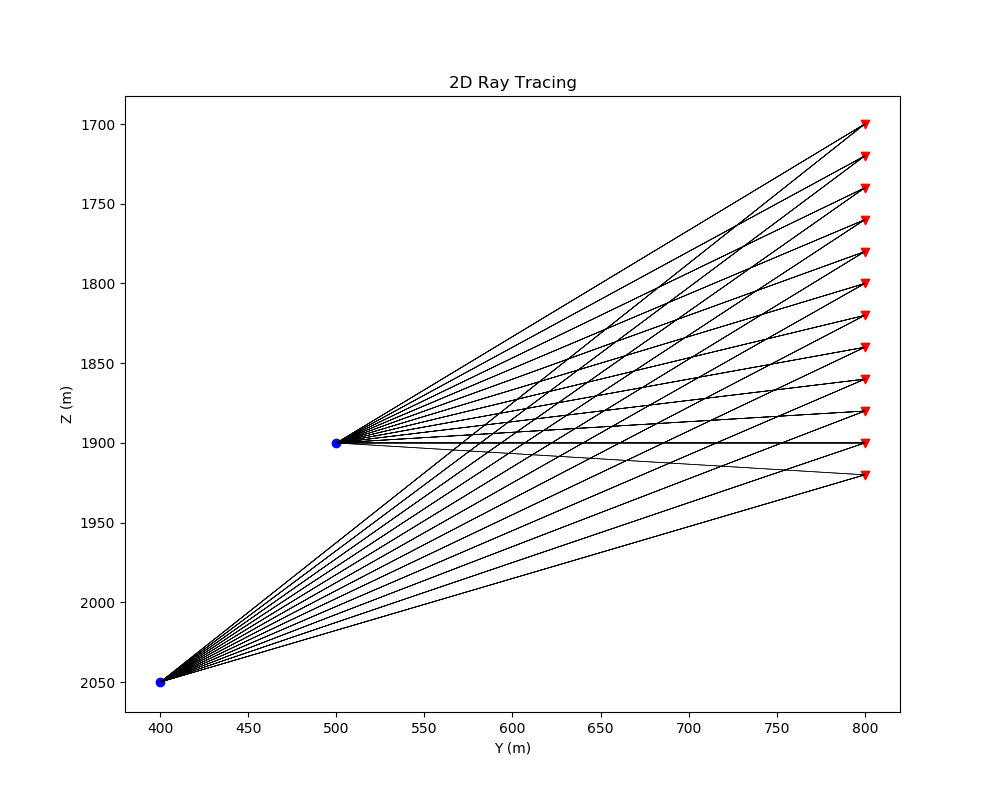

In [40]:
# Raytracing 
dg = 10
depth = vm[:,0]
vp = vm[:,1]
vs = vm[:,2]
times, rays, _ = raytrace(vp, vs, depth, dg, src, rcv)

# Plot rays
# Display sources and receivers locations
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

ax.scatter(rcv[:,1], rcv[:,2], c='r', marker='v')
ax.scatter(src[:,1], src[:,2], c='b', marker='o')
ax.invert_yaxis()
ax.set_xlabel('Y (m)')
ax.set_ylabel('Z (m)')
ax.set_title('2D Ray Tracing')

# Display rays
for i in range(nsrc):
    dx = deepcopy(rays[0, :])
    dy = deepcopy(rays[1, :])
    zh = deepcopy(rays[2, :])

    ax.plot(dy, zh,'k-', linewidth=0.5)
    fig.canvas.draw()


plt.show()

Here's a animated ray tracing plot.

<IPython.core.display.Javascript object>


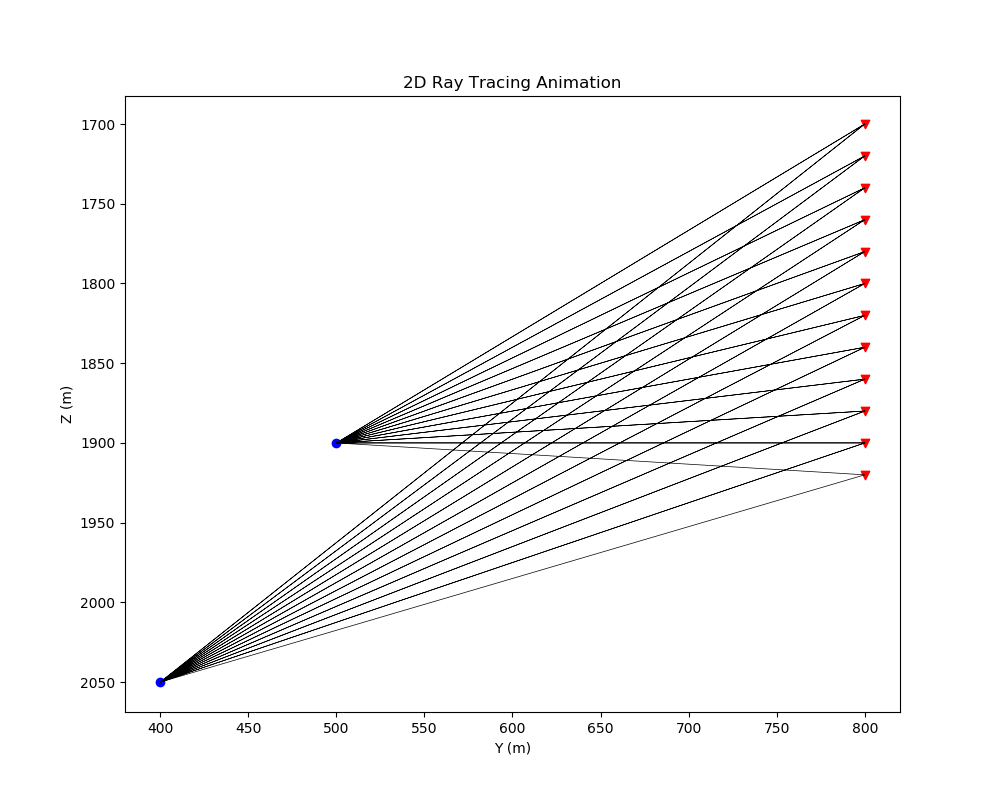

In [41]:
# Plot animated rays
# Display sources and receivers 
import matplotlib.animation as animation

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

ax.scatter(rcv[:,1], rcv[:,2], c='r', marker='v')
ax.scatter(src[:,1], src[:,2], c='b', marker='o')
ax.invert_yaxis()
ax.set_xlabel('Y (m)')
ax.set_ylabel('Z (m)')
ax.set_title('2D Ray Tracing Animation')

ani, = ax.plot([], [],'k-', linewidth=0.5)

ni = len(rays[1,:])
def animate(i):
    dy = rays[1, :i+2]
    zh = rays[2, :i+2]
    ani.set_data(dy, zh)
    return ani,

plot = animation.FuncAnimation(fig, animate, frames=ni-2, 
                              interval=10, blit=True, repeat = False)

    
plt.show()

## 3D example

In [42]:
# define receivers coordinates, (81,3), 9*9 receivers with x,y,z coordinates
rcv = np.ones((81,3), dtype =np.float32)
xy = np.arange(100.,1000.,100)

rcv[:,0] = np.tile(xy,9) # x
rcv[:,1] = np.repeat(xy,9) # y
rcv[:,2] = rcv[:,2] * 0.25 # depth
print('###### Receivers #####')
print(rcv)

# define source coordinates, (3,3), 3 source points with x,y,z coordinates
src = np.ones((3,3), dtype =np.float32)
src[0,:] = np.array([500., 500., 2000.])
src[1,:] = np.array([700., 200., 2050.])
src[2,:] = np.array([300., 650., 2050.])

nsrc = src.shape[0]
print('###### Sources #####')
print(src)

# define layered velocity model, (8,3), 8 layers with depth, vp, vs
vm = np.zeros((5,3), dtype =np.float32)
vm[:,0] = np.array([0., 120., 850., 1680., 2100.]) # depth
vm[:,1] = np.array([1500., 3200., 3800., 4150., 4500.]) # vp
vm[:,2] = vm[:,1]/1.73 # vs
print('###### Layered Velocity Model #####')
print(vm)

###### Receivers #####
[[1.0e+02 1.0e+02 2.5e-01]
 [2.0e+02 1.0e+02 2.5e-01]
 [3.0e+02 1.0e+02 2.5e-01]
 [4.0e+02 1.0e+02 2.5e-01]
 [5.0e+02 1.0e+02 2.5e-01]
 [6.0e+02 1.0e+02 2.5e-01]
 [7.0e+02 1.0e+02 2.5e-01]
 [8.0e+02 1.0e+02 2.5e-01]
 [9.0e+02 1.0e+02 2.5e-01]
 [1.0e+02 2.0e+02 2.5e-01]
 [2.0e+02 2.0e+02 2.5e-01]
 [3.0e+02 2.0e+02 2.5e-01]
 [4.0e+02 2.0e+02 2.5e-01]
 [5.0e+02 2.0e+02 2.5e-01]
 [6.0e+02 2.0e+02 2.5e-01]
 [7.0e+02 2.0e+02 2.5e-01]
 [8.0e+02 2.0e+02 2.5e-01]
 [9.0e+02 2.0e+02 2.5e-01]
 [1.0e+02 3.0e+02 2.5e-01]
 [2.0e+02 3.0e+02 2.5e-01]
 [3.0e+02 3.0e+02 2.5e-01]
 [4.0e+02 3.0e+02 2.5e-01]
 [5.0e+02 3.0e+02 2.5e-01]
 [6.0e+02 3.0e+02 2.5e-01]
 [7.0e+02 3.0e+02 2.5e-01]
 [8.0e+02 3.0e+02 2.5e-01]
 [9.0e+02 3.0e+02 2.5e-01]
 [1.0e+02 4.0e+02 2.5e-01]
 [2.0e+02 4.0e+02 2.5e-01]
 [3.0e+02 4.0e+02 2.5e-01]
 [4.0e+02 4.0e+02 2.5e-01]
 [5.0e+02 4.0e+02 2.5e-01]
 [6.0e+02 4.0e+02 2.5e-01]
 [7.0e+02 4.0e+02 2.5e-01]
 [8.0e+02 4.0e+02 2.5e-01]
 [9.0e+02 4.0e+02 2.5e-01]
 [1.0

c:\users\zhao\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:224: RuntimeWarning: invalid value encountered in true_divide
c:\users\zhao\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:231: RuntimeWarning: invalid value encountered in multiply
c:\users\zhao\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:232: RuntimeWarning: invalid value encountered in multiply
c:\users\zhao\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:232: RuntimeWarning: invalid value encountered in true_divide
c:\users\zhao\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in arcsin


<IPython.core.display.Javascript object>


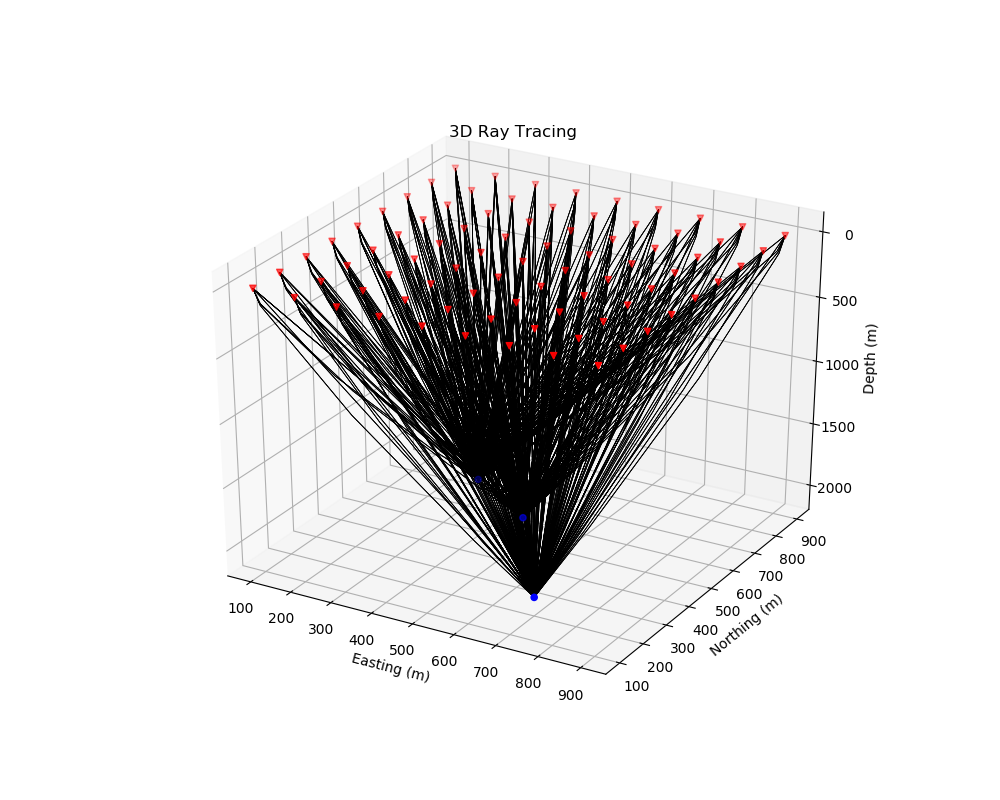

In [43]:
# Raytracing 
dg = 10
depth = vm[:,0]
vp = vm[:,1]
vs = vm[:,2]
times, rays, _ = raytrace(vp, vs, depth, dg, src, rcv)

# Plot rays
# Display sources and receivers locations
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rcv[:,0], rcv[:,1], rcv[:,2], c='r', marker='v')
ax.scatter(src[:,0], src[:,1], src[:,2], c='b', marker='o')
ax.invert_zaxis()
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_zlabel('Depth (m)')
ax.set_title('3D Ray Tracing')

# Display rays
for i in range(nsrc):
    dx = deepcopy(rays[0, :])
    dy = deepcopy(rays[1, :])
    zh = deepcopy(rays[2, :])

    ax.plot(dx, dy, zh,'k-', linewidth=0.5)
    fig.canvas.draw()


plt.show()

Here's an animated plot of 3D raytracing.

<IPython.core.display.Javascript object>


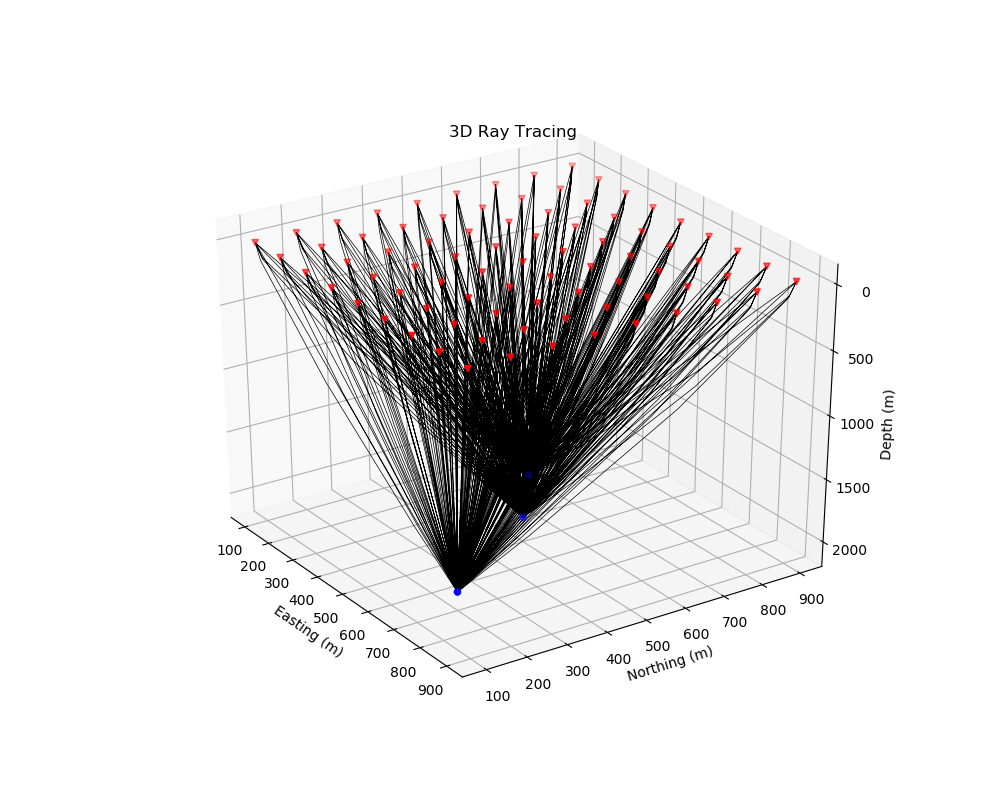

In [44]:
# Plot rays in 3D animation
# Display sources and receivers locations
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rcv[:,0], rcv[:,1], rcv[:,2], c='r', marker='v')
ax.scatter(src[:,0], src[:,1], src[:,2], c='b', marker='o')
ax.invert_zaxis()
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_zlabel('Depth (m)')
ax.set_title('3D Ray Tracing')

# animation
ani, = ax.plot([],[],[],'k-', linewidth=0.5)
ni = len(rays[0, :])

def init():
    ani.set_data([], [])
    return ani,

def animate(i):
    dx = rays[0, :i+2]
    dy = rays[1, :i+2]
    zh = rays[2, :i+2]
    ani.set_data(dx, dy)
    ani.set_3d_properties(zh)
    return ani,

plot = animation.FuncAnimation(fig, animate, frames=ni-2, 
                              interval=10, blit=True, init_func = init, repeat = False)


plt.show()